In [ ]:
#image segmentation using vgg encoder. Output layer is batch_size x m x n x nclasses (4-D). No data Augmentation
import numpy as np
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, concatenate, Lambda 
from keras.preprocessing.image import ImageDataGenerator

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

batch_size=2
nepochs=5
nclasses=12

 
def unet_with_vgg_encoder():
  pretrained_model=VGG16(include_top=False, weights='imagenet', input_shape=(360, 480,3))   
  pretrained_model.summary()

  input_layer=pretrained_model.input
  output_layer_pretrained=pretrained_model.layers[-6].output
  
  encoder=Model(input_layer, output_layer_pretrained)
  for i in encoder.layers:
    i.trainable=False

  encoder.summary()

  lastPooling=MaxPooling2D(pool_size=(2,2),padding='same')(output_layer_pretrained)  #notice padding, output shape of output_layer_pretrained is (None, 45, 60, 512) 
  center=Conv2D(1024, (3,3), activation='relu', padding='same')(lastPooling) #pretrained VGG16 has used 'same' Convolution
  center=Conv2D(1024, (3,3), activation='relu', padding='same')(center)
  center=BatchNormalization()(center)

  up4=UpSampling2D((2,2))(center) #output shape is now (None, 46, 60, 1024 )
  up4=Conv2D(512, (2,2), activation='relu', padding='same')(up4) #output shape is now (None, 46, 60, 512 )
  up4=Lambda(lambda x: x[:,0:45,:,:])(up4)     #lambda arguments : expression, The expression is executed and the result is returned
  up4=concatenate([up4,encoder.get_layer(name='block4_conv3').output], axis=3) #output shape is now (None, 45, 60, 1024 )
  up4=Conv2D(512, (3,3), activation='relu', padding='same')(up4) #output shape is now (None, 45, 60, 512)
  up4=Conv2D(512, (3,3), activation='relu', padding='same')(up4) #output shape is (None, 45, 60, 512)
  up4=Conv2D(512, (3,3), activation='relu', padding='same')(up4) #output shape is (None, 45, 60, 512)
  up4=BatchNormalization()(up4)

  up3=UpSampling2D((2,2))(up4) #output shape is now (None, 90, 120, 512)
  up3=Conv2D(256, (2,2), activation='relu', padding='same')(up3) #output shape is now (None, 90, 120, 256)
  up3=concatenate([up3,encoder.get_layer(name='block3_conv3').output], axis=3) #output shape is now (None, 90, 120, 512)
  up3=Conv2D(256, (3,3), activation='relu', padding='same')(up3) #output shape is now (None, 90, 120, 256)
  up3=Conv2D(256, (3,3), activation='relu', padding='same')(up3) #output shape is now (None, 90, 120, 256)
  up3=Conv2D(256, (3,3), activation='relu', padding='same')(up3) #output shape is now (None, 90, 120, 256)
  up3=BatchNormalization()(up3)

  up2=UpSampling2D((2,2))(up3) #output shape is now (None, 180, 240, 256)
  up2=Conv2D(128, (2,2), activation='relu', padding='same')(up2)  #output shape is now (None, 180, 240, 128)
  up2=concatenate([up2,encoder.get_layer(name='block2_conv2').output], axis=3) #output shape is now (None, 180, 240, 256)
  up2=Conv2D(128, (3,3), activation='relu', padding='same')(up2) #output shape is now (None, 180, 240, 128)
  up2=Conv2D(128, (3,3), activation='relu', padding='same')(up2) #output shape is now (None, 180, 240, 128)
  up2=BatchNormalization()(up2)

  up1=UpSampling2D((2,2))(up2) #output shape is now (None, 360, 480, 128)
  up1=Conv2D(64, (2,2), activation='relu', padding='same')(up1) #output shape is now (None, 360, 480, 64)
  up1=concatenate([up1,encoder.get_layer(name='block1_conv2').output], axis=3) #output shape is now (None, 360, 480, 128)
  up1=Conv2D(64, (3,3), activation='relu', padding='same')(up1) #output shape is now (None, 360, 480, 64)
  up1=Conv2D(64, (3,3), activation='relu', padding='same')(up1) #output shape is now (None, 360, 480, 64)
  up1=Conv2D(nclasses, (1,1), activation='softmax', padding='same')(up1) #output shape is now (None, 360, 480, 12)

  model=Model(inputs=input_layer, outputs=up1)
  model.summary()
  return model

def traingenerator():
  image_datagen = ImageDataGenerator(rescale=1/255) 
  mask_datagen = ImageDataGenerator()

  image_batch_generator = image_datagen.flow_from_directory(
      directory='/content/drive/MyDrive/dataset1/images_train',
      class_mode=None, target_size=(360,480), shuffle=False, seed=2019, batch_size=batch_size, color_mode='rgb')

  mask_batch_generator = mask_datagen.flow_from_directory(
      directory='/content/drive/MyDrive/dataset1/annotations_train',
      class_mode=None, target_size=(360,480), shuffle=False, color_mode='grayscale', seed=2019, batch_size=batch_size)

  combined_generator=zip(image_batch_generator, mask_batch_generator)

  
  for (i,j) in combined_generator:
    new_mask=np.zeros(shape=(j.shape[0], j.shape[1], j.shape[2], nclasses)) #using batch_size in place of j.shape[0] will cause a problem with the next line as last batch will just have 1 image, mask pair
    for k in range(j.shape[0]):  #using batch_size in place of j.shape[0] will cause a problem with the next line as last batch will just have 1 image, mask pair
      mask=j[k]
      for m in range(nclasses):
        new_mask[k,:,:,m] = mask[:,:,0]==m
    yield(i,new_mask)

def testgenerator():
  image_datagen_test = ImageDataGenerator(rescale=1/255) 
  
  image_batch_generator_test = image_datagen_test.flow_from_directory(
      directory='/content/drive/MyDrive/dataset1/images_test',
      class_mode=None, target_size=(360,480), shuffle=False, seed=2019, batch_size=batch_size, color_mode='rgb')
  
  for i in image_batch_generator_test:
    yield i

unet=unet_with_vgg_encoder()
unet.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 480, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 480, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 480, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 240, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 240, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 240, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Epoch 1/5
184/184 [==============================] - 240s 1s/step - loss: 1.0740 - accuracy: 0.6880
Epoch 2/5
184/184 [==============================] - 212s 1s/step - loss: 0.7933 - accuracy: 0.7552
Epoch 3/5
184/184 [==============================] - 212s 1s/step - loss: 0.6963 - accuracy: 0.7825
Epoch 4/5
184/184 [==============================] - 212s 1s/step - loss: 0.6390 - accuracy: 0.7995
Epoch 5/5
184/184 [==============================] - 212s 1s/step - loss: 0.5900 - accuracy: 0.8175
Found 101 images belonging to 1 classes.


In [ ]:
unet.fit(traingenerator(), steps_per_epoch=184, epochs=1)


Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
184/184 [==============================] - 213s 1s/step - loss: 0.5427 - accuracy: 0.8329


In [ ]:
results=unet.predict(testgenerator(),steps=51)

Found 101 images belonging to 1 classes.


In [ ]:
import os

path = os.path.join("/content/drive/MyDrive/Annotation")
final = os.path.join(path, 'UNET-model.h5')
os.path.exists(path)


True

In [ ]:
results.shape

(101, 360, 480, 12)

In [ ]:
unet.save(final)

In [ ]:
msk = results[0]

In [ ]:
def save(msk):
    ind = np.argmax(msk, axis = 2)
    img = np.zeros(msk.shape[:2])
    for i in range(msk.shape[0]):
        for j in range(msk.shape[1]):
            img[i][j] = msk[i][j][ind[i][j]]
    return img

In [ ]:
import cv2
save_path = os.path.join("/content/drive/MyDrive/Annotation")
#save_path = os.path.join(path, 'ans')
#os.path.exists(save_path)
for i in range(len(results)):
    img = save(results[i])
    file = os.path.join(save_path, str(i + 1) + '.jpg')
    plt.imsave(file, img)



In [ ]:
plt.imsave(file, img)

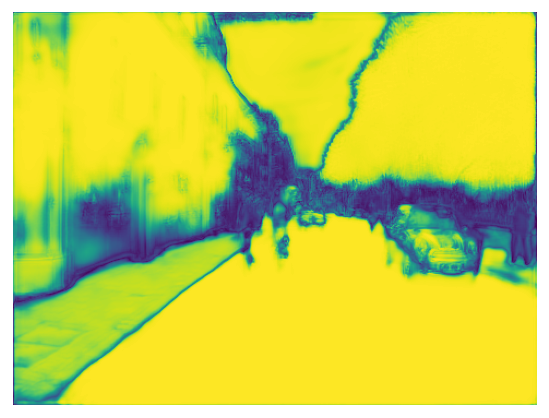

In [ ]:
img = save(results[0])
plt.figure(dpi = 130)
plt.imshow(img)
plt.axis('off');